# Kyber $\texttt{poly}\_\texttt{tomsg}$ Side Channel Analysis 

This Notebook contains:
- Leakage Detection on the $\texttt{poly}\_\texttt{tomsg}$ function from `poly.c`
- Side Channel Assisted Chosen Ciphertext Attack based on the identified leakage
----- 

## Preliminaries

Choose the security strength of Kyber:  
- For Kyber-512 choose  `K = 2`
- For Kyber-768 choose  `K = 3`
- For Kyber-1024 choose `K = 4`

In [1]:
K = 2
# K = 3
# K = 4

In [2]:
# Loading kyber parameters according to the chosen security level K
%run -i ../Common_functions/Kyber_parameters.py {K}

# Loading auxiliary functions
%run -i ../Common_functions/Kyber_functions.py

# Loading auxiliary functions
%run -i ../Common_functions/Additional_functions.py

In [3]:
# Importing useful libraries
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [4]:
# Setting default size of figures in Matplotlib
plt.rcParams["figure.figsize"] = (13, 3) 

# Set the maximum display width for NumPy arrays
np.set_printoptions(linewidth=100)

# Adjusting the display of tables
np.set_printoptions(threshold=10) 

In [5]:
# Set here the path to the traces for building
global_path_building = "./Dataset_building/"

# Set here the path to the traces for matching
global_path_matching = "./Dataset_matching/"

In [6]:
# Matplotlib constants 
span_color = "#FFC069"
color1 = "gold"
color0 = "rebeccapurple"

-----
## Leakage Detection

### Loading the datasets

In [7]:
name_of_file = f"{global_path_building}datasets_building.npz"
files = np.load(name_of_file)

name_files = files.files
print(f"Files found in {name_of_file}:")
for name_file in name_files:
    print(f" - {name_file} containing {files[name_file].shape[0]} traces of {files[name_file].shape[1]} samples each")

print("")

Files found in ./Dataset_building/datasets_building.npz:
 - dataset_building_rounded0 containing 42 traces of 24400 samples each
 - dataset_building_rounded1 containing 42 traces of 24400 samples each



In [8]:
# Load the dataset for negative messages rounded to 0 after the compress
dataset_building_rounded0 = files[name_files[0]]

In [9]:
# Load the dataset for negative messages rounded to 1 after the compress
dataset_building_rounded1 = files[name_files[1]]

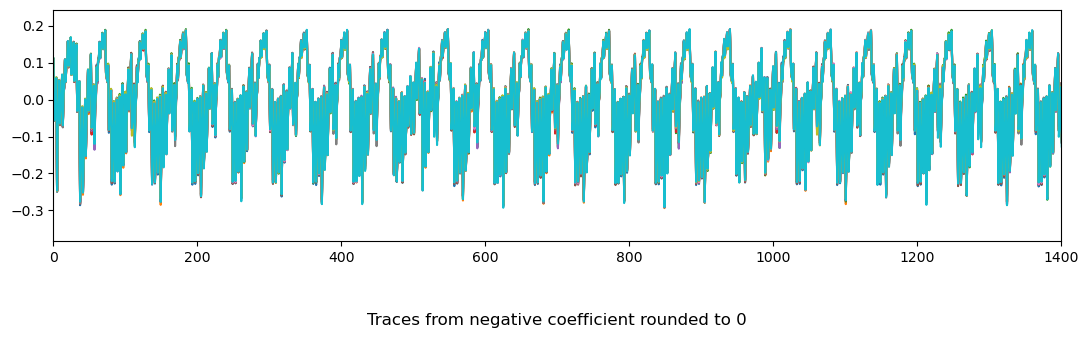

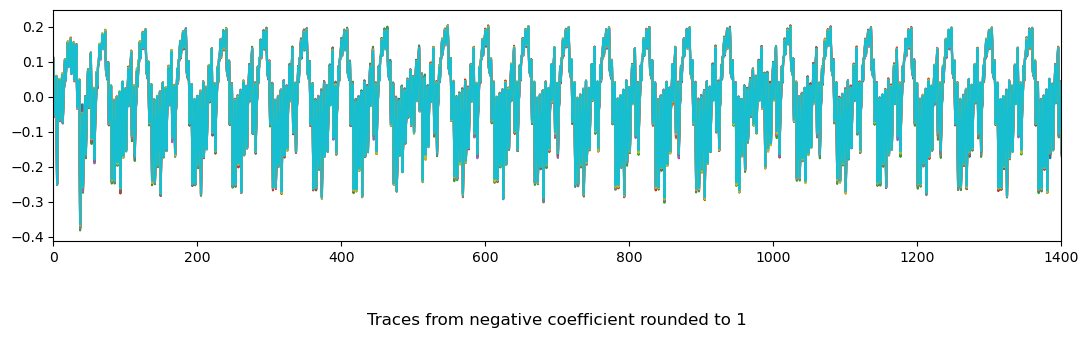

In [10]:
# Visualizing 10 traces from each dataset
plt.plot(dataset_building_rounded0[:10].T)
plt.xlim(0,1400)
plt.title("Traces from negative coefficient rounded to 0",y=-0.4)
plt.show()

plt.plot(dataset_building_rounded1[:10].T)
plt.xlim(0,1400)
plt.title("Traces from negative coefficient rounded to 1",y=-0.4)
plt.show()

### T-test between the two datasets 

As a first indicator, let's visualize the t-test between our two datasets

In [11]:
t_value = ttest_ind(dataset_building_rounded0, dataset_building_rounded1, axis = 0, equal_var = False)[0]

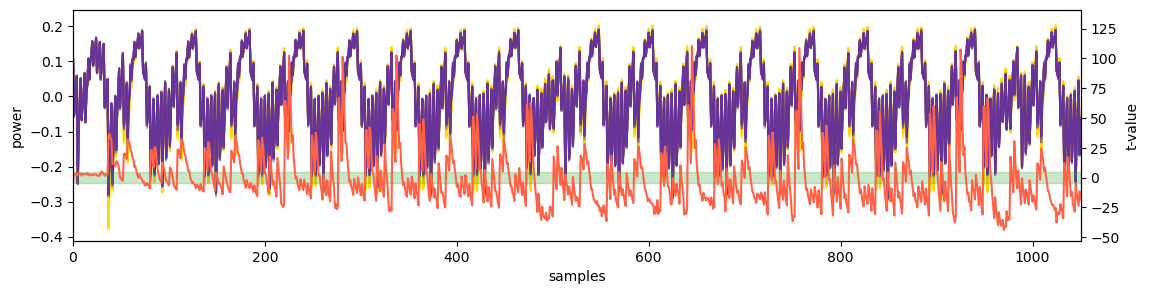

In [12]:
fg, ax = plt.subplots(figsize = (13, 3))

# Visualizing 10 traces from each dataset
ax.plot(np.transpose(dataset_building_rounded1[:10]), color = color1, alpha=0.4)
ax.plot(np.transpose(dataset_building_rounded0[:10]), color = color0, alpha=0.4)

ax2 = ax.twinx()
ax2.plot(t_value, color = "tomato", alpha = 1)
ax.set_xlabel("samples")
ax.set_ylabel("power")
ax2.set_ylabel("t-value")

# Significance threshold
plt.axhspan(-4.5, 4.5, color = "C2", alpha = 0.25)
            
plt.xlim(0, 1050)

plt.show()

### Determining repeating patterns 

> ⚠️ This is a **quick** and **dirty** method only destined to be used for the sake of this attack  

Here, we will try to automatically detect the patterns corresponding to the compressing of each coefficient

In [13]:
# We retrieve the number of samples/cycles ratio of the CW (by default this is 4)
cw_sample_cycle_ratio = 4
 
# Making an educated guess on how many samples at the beginning of the trace correspond to the trigger
cw_trigger_offset     = 6 * cw_sample_cycle_ratio

Let's analyze the C code from [github.com/pq-crystals/kyber/](https://github.com/pq-crystals/kyber/blob/main/ref/poly.c):

```c
void poly_tomsg(uint8_t msg[KYBER_INDCPA_MSGBYTES], const poly *a){
  unsigned int i,j;
  uint32_t t;
  uint32_t  mask;
  for(i=0;i<KYBER_N/8;i++) {
    msg[i] = 0;
    for(j=0;j<8;j++) {
      t  = a->coeffs[8*i+j];
      // t += ((int16_t)t >> 15) & KYBER_Q;
      // t  = (((t << 1) + KYBER_Q/2)/KYBER_Q) & 1;
      t <<= 1;
      t += 1665;
      t *= 80635;
      t >>= 28;
      t &= 1;
      msg[i] |= t << j;   

    }
  }
}
``` 

In [14]:
# We have 7 lines for the compression of one coefficient (code block inside the second `for` loop). 
nb_c_lines = 7

# Let's guess that we will have at least cw_sample_cycle_ratio x 7 samples, for the operation we target 
min_samples_compress = cw_sample_cycle_ratio * nb_c_lines

# As a maximum let's guess that this can result in 2 cycles per C line
max_samples_compress = 2 * min_samples_compress

To start, we will focus on one full iteration of the second `for` loop  
We can see that we will have 8 succesive compress somewhere in the beginning of the trace  
So in the first samples of one trace we should have:
* a few samples related to the chipwhisperer trigger process
* some more few samples for the start of `for` loops
* 8 patterns corresponding to the compress
* some extra samples between the patterns for the logic behind the `for` loops

In [15]:
# The number of coefficient for the whole second for loop
nb_coeffs                   = 8

# An educated guess on how much samples are taken at the beginning of the poly_tomsg function
start_function_offset       = 6 * cw_sample_cycle_ratio

# Another educated guess on how much other operations are accounted for in the trace
other_operations_samples    = 4 * cw_sample_cycle_ratio

# Combining everything we have the approximate duration of the second for loop
approximate_len_1for_j_loop =  cw_trigger_offset + start_function_offset\
                              + nb_coeffs * max_samples_compress\
                              + other_operations_samples 

Now that we have determined this smaller window, we can restrict our dataset to the part that we are analyzing

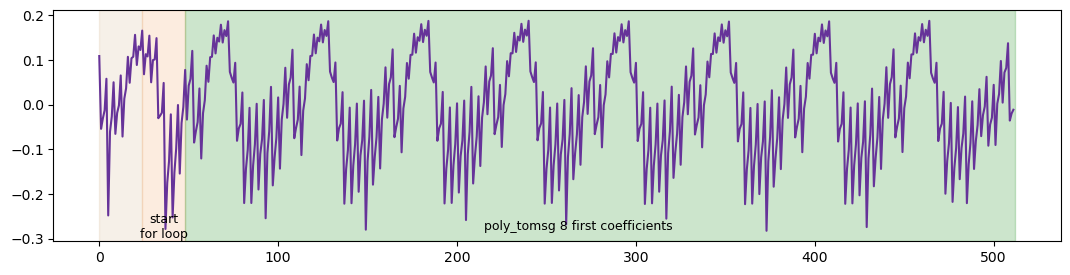

In [16]:
data = np.mean(dataset_building_rounded0, axis = 0)[:approximate_len_1for_j_loop]

# Visualize the data with the identified operations 
plt.plot(data, color = color0)
plt.axvspan(0, cw_trigger_offset, color = "tan", alpha = 0.2)
y_pos = np.min(data) + 0.01

plt.axvspan(cw_trigger_offset, cw_trigger_offset + start_function_offset, color = "sandybrown", alpha = 0.2)
x_pos = (cw_trigger_offset + start_function_offset + cw_trigger_offset)/2
plt.text(x_pos, y_pos, 'start\nfor loop', horizontalalignment='center', verticalalignment='center', fontsize=9)

plt.axvspan(cw_trigger_offset + start_function_offset, cw_trigger_offset + start_function_offset + nb_coeffs * max_samples_compress + other_operations_samples, color = "green", alpha = 0.2)
x_pos = (cw_trigger_offset + start_function_offset + nb_coeffs * max_samples_compress + other_operations_samples + cw_trigger_offset)/2
plt.text(x_pos, y_pos, f'poly_tomsg {nb_coeffs} first coefficients', horizontalalignment='center', verticalalignment='center', fontsize=9)

plt.show()

After checking that everything looks good, we are ready to detect some patterns 

In [17]:
# The minimal correlation tolerated between patterns
limit = 0.99

# The number of patterns tolerated with a correlation inferior to limit
nb_not_good = 0

In [18]:
%%time
cpt_good_candidates = 0

GOOD_CANDIDATES = []

# Brute-forcing through all the starting points 
for start_point in range(cw_trigger_offset + start_function_offset, cw_trigger_offset + start_function_offset + cw_sample_cycle_ratio*4):
    # Iterating through all the possible pattern lengths, starting from the largest
    for length in range(max_samples_compress, min_samples_compress-1, -1):
        # Maximum spacing between patterns so that we don't go outside the trace
        max_spacing = (len(data) - start_point - nb_coeffs*length-1)//(nb_coeffs-1)

        # Iterating through all the possible spacing lengths, starting from the largest
        for spacing in range(max_spacing, -1, -1):
            potential_windows, window_start_index, window_end_index = [], [], []
            
            # Compute the first pattern, start point of window, end point of window and samples
            new_window_start = start_point
            window_start_index.append(new_window_start)

            new_window_end   = new_window_start + length
            window_end_index.append(new_window_end)

            potential_windows.append(data[new_window_start : new_window_end])
            
            # Compute the other patterns based on the first one 
            for window_index in range(1, nb_coeffs):
                new_window_start = new_window_end + spacing
                window_start_index.append(new_window_start)

                new_window_end   = new_window_start + length
                window_end_index.append(new_window_end)

                potential_windows.append(data[new_window_start : new_window_end])
            
            # Quality of matching patterns
            measure = np.corrcoef(potential_windows)

            if np.count_nonzero(measure <= limit) <= nb_not_good:
                cpt_good_candidates += 1
                GOOD_CANDIDATES.append([window_start_index, window_end_index, potential_windows])

print(f">>> You have found {len(GOOD_CANDIDATES)} good matching patterns candidates", end = "\n\n")

>>> You have found 356 good matching patterns candidates

CPU times: user 336 ms, sys: 0 ns, total: 336 ms
Wall time: 336 ms


Displaying 10 out of 356 good matching patterns candidates:
>>> Candidate #0


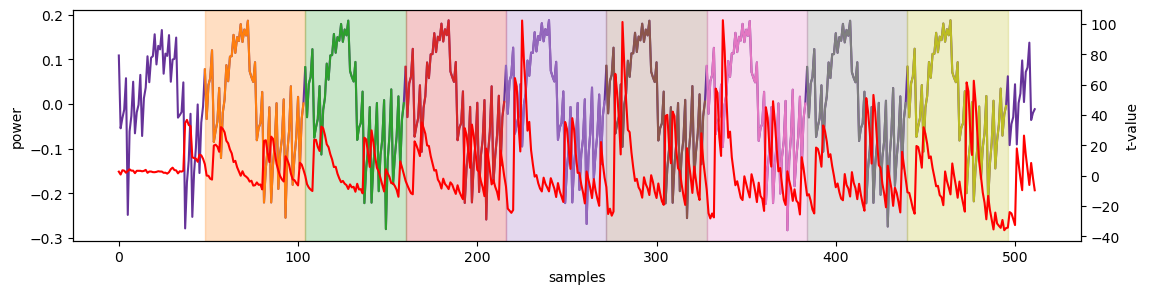

>>> Candidate #1


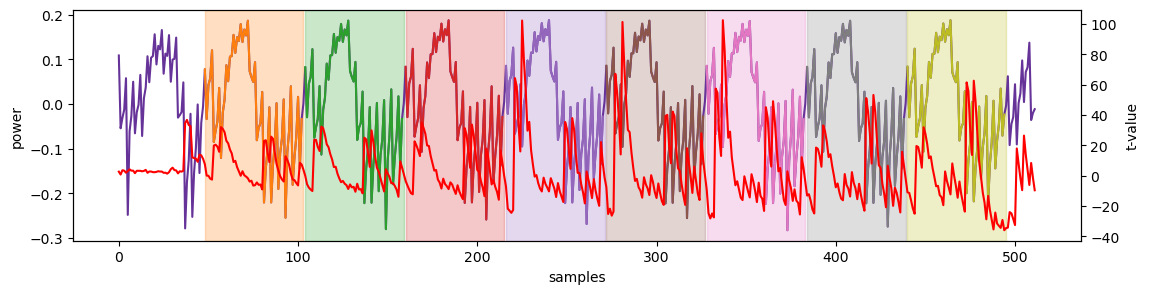

>>> Candidate #2


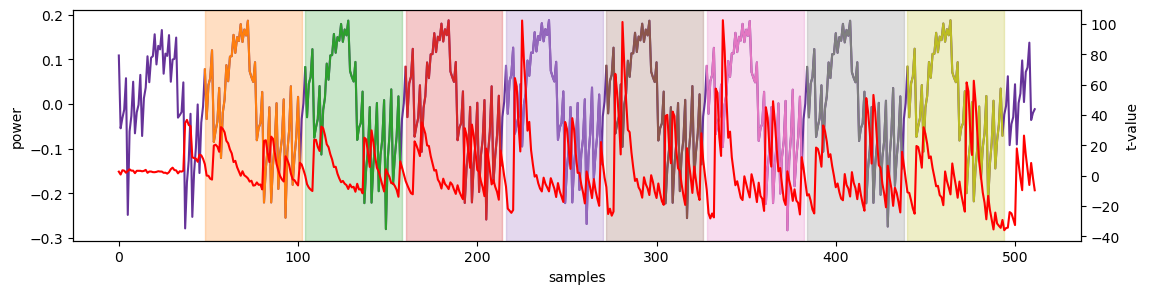

>>> Candidate #3


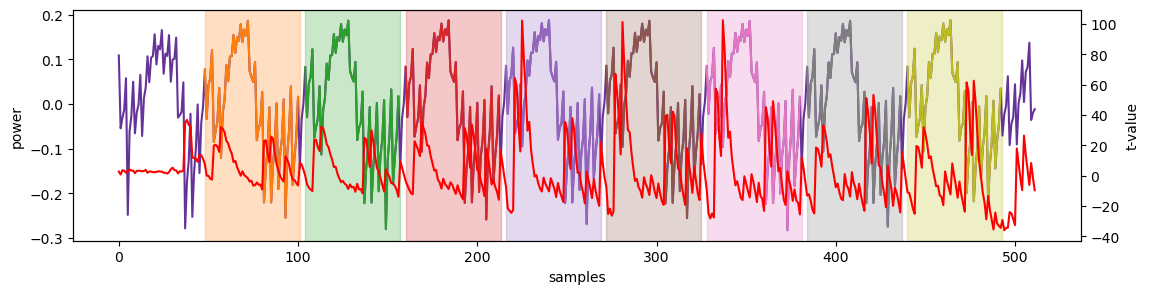

>>> Candidate #4


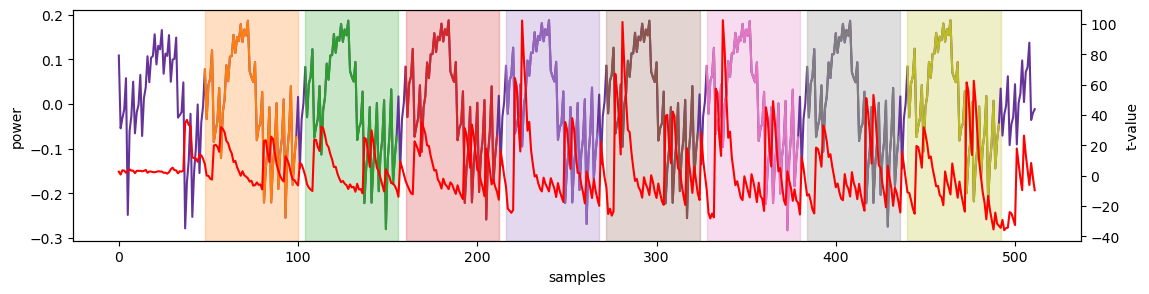

>>> Candidate #5


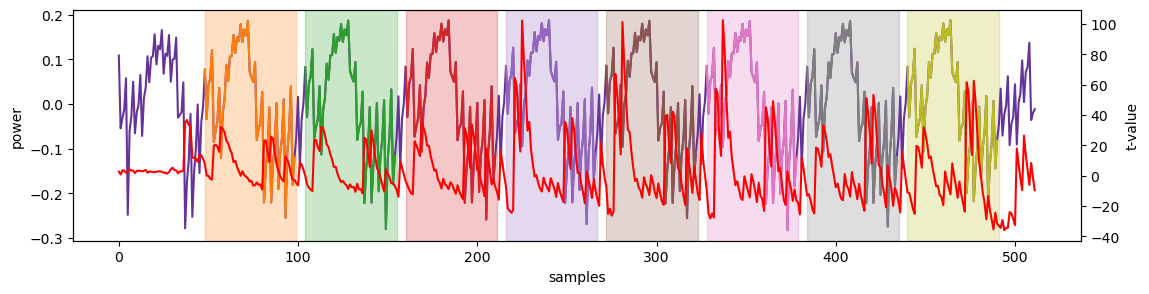

>>> Candidate #6


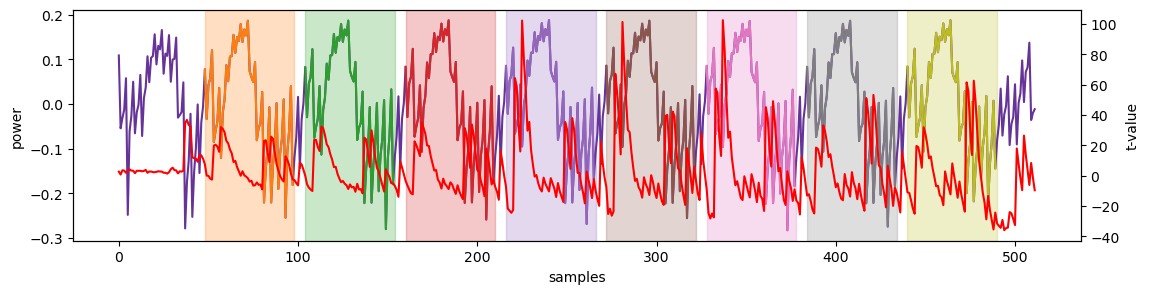

>>> Candidate #7


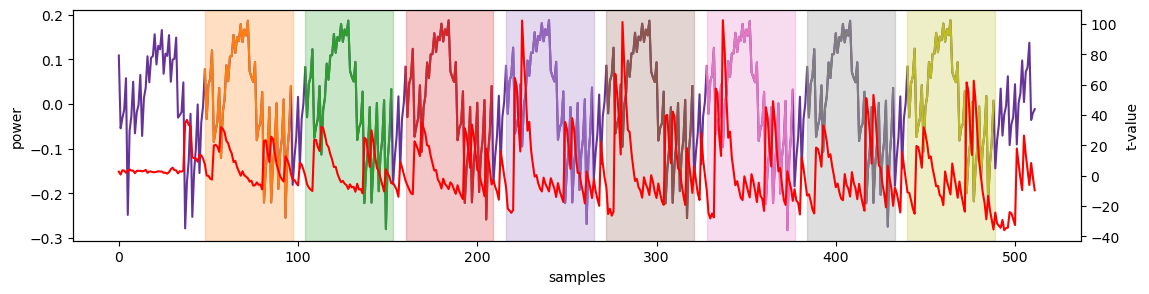

>>> Candidate #8


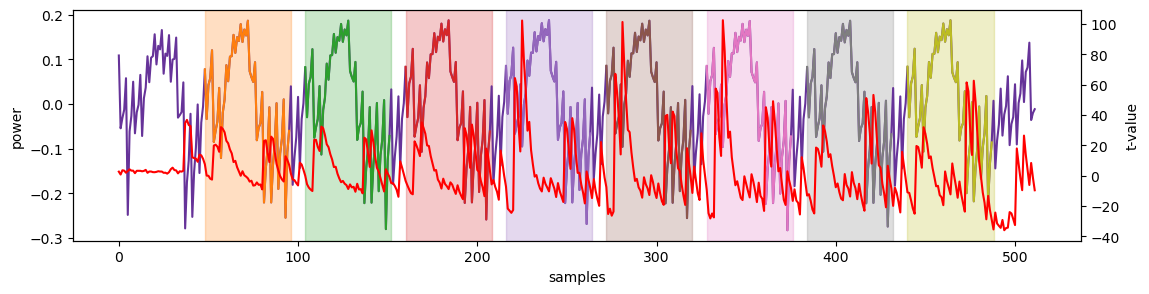

>>> Candidate #9


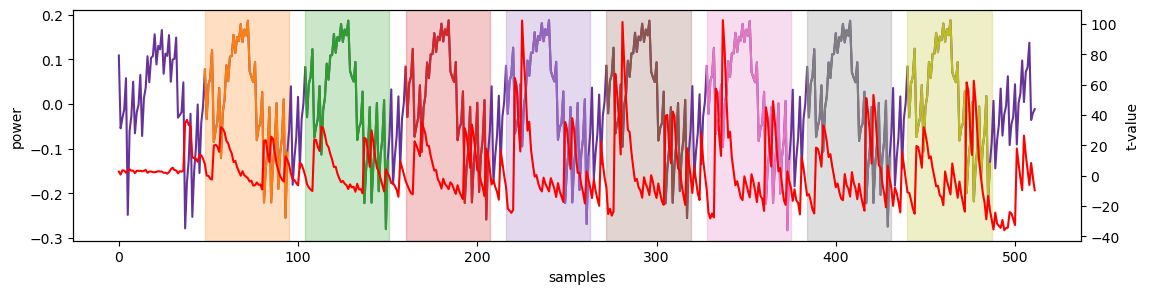

In [19]:
# Visualizing all the good candidates previously found (can take a few seconds)
nb_candidates_displayed = 10

print(f"Displaying {nb_candidates_displayed} out of {len(GOOD_CANDIDATES)} good matching patterns candidates:")
for windows_index, element in enumerate(GOOD_CANDIDATES[:min(len(GOOD_CANDIDATES), nb_candidates_displayed)]):
    print(f">>> Candidate #{windows_index}")
    window_start_index, window_end_index, potential_windows = element
    
    fig, ax = plt.subplots(figsize = (13, 3))
    ax.plot(data, color = color0, alpha = 1)
    for window_index in range(0, len(potential_windows)):
        plt.plot(range(window_start_index[window_index], window_end_index[window_index]), potential_windows[window_index], color = f"C{window_index+1}")
        plt.axvspan(window_start_index[window_index], window_end_index[window_index], color = f"C{window_index+1}", alpha = 0.25)
    ax.set_xlabel("samples")
    ax.set_ylabel("power")
    
    ax2 = ax.twinx()
    ax2.plot(t_value[:approximate_len_1for_j_loop],color="red", alpha=1)
    ax2.set_ylabel("t-value")
    plt.show()

In [20]:
# Select one candidate that looks good (by default the first one)
index_chosen =  0

# global compress_index_start, compress_index_end
compress_index_start, compress_index_end, potential_windows = GOOD_CANDIDATES[index_chosen]

In [21]:
# Based of this candidate set of patterns we can determine some constants 
# Start of the first poly_tomsg
start_index_compress_coeff0 = compress_index_start[0]

# Length of the first poly_tomsg
approximate_length_compress_coeff = compress_index_end[0] - compress_index_start[0]

# Distance between two for j loops
distance_forj_loop_forj_loop = compress_index_start[1] - compress_index_end[0]

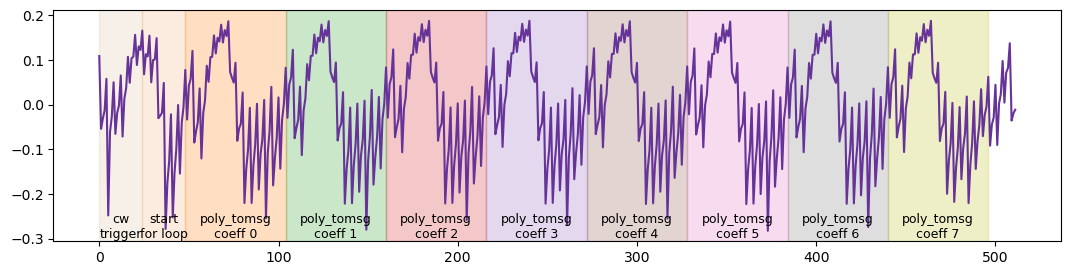

In [22]:
plt.plot(data, color = color0)

# Visualize the data with the identified operations 
plt.axvspan(0, cw_trigger_offset, color = "tan", alpha = 0.2)
y_pos = np.min(data) + 0.01
x_pos = (cw_trigger_offset + 0)/2
plt.text(x_pos,y_pos, 'cw\ntrigger', horizontalalignment='center', verticalalignment='center', fontsize=9)

plt.axvspan(cw_trigger_offset, cw_trigger_offset + start_function_offset, color = "sandybrown", alpha = 0.2)
x_pos = (cw_trigger_offset + start_function_offset + cw_trigger_offset)/2
plt.text(x_pos, y_pos, 'start\nfor loop', horizontalalignment='center', verticalalignment='center', fontsize=9)

for compress_index in range(0, nb_coeffs):
    start_window, end_window = compress_index_start[compress_index], compress_index_end[compress_index]
    plt.axvspan(start_window, end_window, color = f"C{compress_index+1}", alpha = 0.25)
    x_pos = (end_window + start_window)/2
    plt.text(x_pos, y_pos, f'poly_tomsg\ncoeff {compress_index}', horizontalalignment='center', verticalalignment='center', fontsize=9)

plt.show()

The 8 patterns identified should hopefully correspond to the compression of the 8 first coefficients  

We can use them to identify the rest  

In [23]:
# One more educated guess on how much other operations are accounted for on the trace 
other_operations_samples    = 16 * cw_sample_cycle_ratio

# Combining everything we have the approximate length of another iterationn of the second for loop
approximate_len_2for_j_loop =  cw_trigger_offset + start_function_offset\
                             + 2*(compress_index_end[-1]- compress_index_start[0])\
                             + other_operations_samples

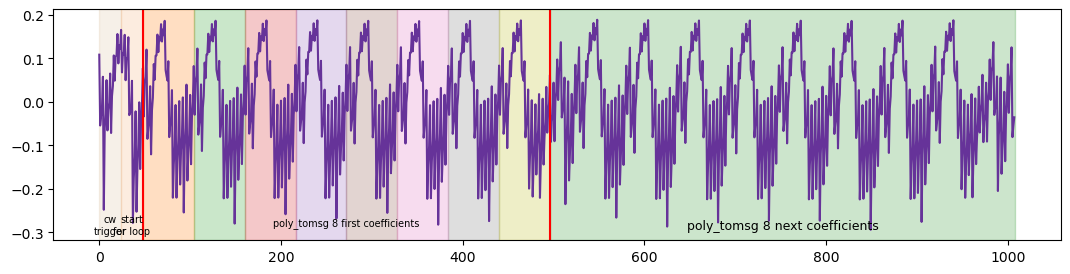

In [24]:
data = np.mean(dataset_building_rounded0, axis = 0)[:approximate_len_2for_j_loop]

# Visualize the data with the identified operations 
plt.plot(data, color = color0)
plt.axvspan(0, cw_trigger_offset, color = "tan", alpha = 0.2)
y_pos = np.min(data) + 0.01
x_pos = (cw_trigger_offset + 0)/2
plt.text(x_pos,y_pos, 'cw\ntrigger', horizontalalignment='center', verticalalignment='center', fontsize=7)

plt.axvspan(cw_trigger_offset, cw_trigger_offset + start_function_offset, color = "sandybrown", alpha = 0.2)
x_pos = (cw_trigger_offset + start_function_offset + cw_trigger_offset)/2
plt.text(x_pos, y_pos, 'start\nfor loop', horizontalalignment='center', verticalalignment='center', fontsize=7)

plt.axvline(compress_index_start[0], color ="red")
plt.axvline(compress_index_end[-1], color ="red")

x_pos = (compress_index_end[-1]+compress_index_start[0])/2
plt.text(x_pos, y_pos, f'poly_tomsg {nb_coeffs} first coefficients', horizontalalignment='center', fontsize=7)

for compress_index in range(0, nb_coeffs):
    start_window, end_window = compress_index_start[compress_index], compress_index_end[compress_index]
    plt.axvspan(start_window, end_window, color = f"C{compress_index+1}", alpha = 0.25)

plt.axvspan(compress_index_end[-1], approximate_len_2for_j_loop, color = "green", alpha = 0.2)
x_pos = (compress_index_end[-1] + approximate_len_2for_j_loop)/2
plt.text(x_pos, y_pos, f'poly_tomsg {nb_coeffs} next coefficients', horizontalalignment='center', verticalalignment='center', fontsize=9)

plt.show()

In [25]:
%%time
# Choose one coefficient as a reference to detect the next batch (default 0)
coeffref = 0
start_window, end_window = compress_index_start[coeffref], compress_index_end[coeffref]
window_compress_coeffref = data[start_window : end_window]

for start_point in range(compress_index_end[-1], approximate_len_2for_j_loop - approximate_length_compress_coeff):
    potential_window_compress_coeff = data[start_point : start_point + approximate_length_compress_coeff]
    measure = np.corrcoef(window_compress_coeffref, potential_window_compress_coeff)
    if measure[0][1] >= limit:
        potential_distance_fori_loop_forj_loop  = start_point - compress_index_end[-1]
        print(f"Good window found ({start_point}, {start_point + len(window_compress_coeffref)}) with quality {measure[0][1]}")
        break

Good window found (524, 580) with quality 0.999075466948148
CPU times: user 5.74 ms, sys: 9.54 ms, total: 15.3 ms
Wall time: 4.98 ms


In [26]:
# Distance between the for i and for j loops
distance_fori_loop_forj_loop = potential_distance_fori_loop_forj_loop

Automate the computation of window given the index

In [27]:
def get_compress_index_window(compress_index):
    start_compress_index =  start_index_compress_coeff0\
                          + compress_index*approximate_length_compress_coeff\
                          + (compress_index//nb_coeffs)*(nb_coeffs-1)*distance_forj_loop_forj_loop\
                          + (compress_index%nb_coeffs)*distance_forj_loop_forj_loop\
                          + (compress_index//nb_coeffs)*distance_fori_loop_forj_loop
    end_compress_index   = start_compress_index + approximate_length_compress_coeff
    return start_compress_index, end_compress_index
    

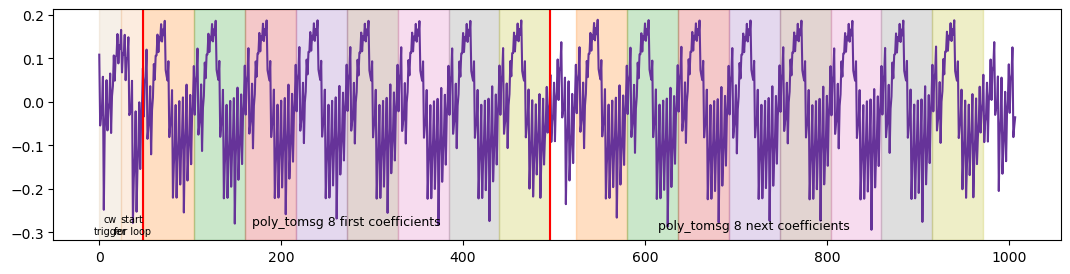

In [28]:
plt.plot(data, color = color0)
plt.axvspan(0, cw_trigger_offset, color = "tan", alpha = 0.2)
y_pos = np.min(data) + 0.01
x_pos = (cw_trigger_offset + 0)/2
plt.text(x_pos,y_pos, 'cw\ntrigger', horizontalalignment='center', verticalalignment='center', fontsize=7)

plt.axvspan(cw_trigger_offset, cw_trigger_offset + start_function_offset, color = "sandybrown", alpha = 0.2)
x_pos = (cw_trigger_offset + start_function_offset + cw_trigger_offset)/2
plt.text(x_pos, y_pos, 'start\nfor loop', horizontalalignment='center', verticalalignment='center', fontsize=7)

plt.axvline(compress_index_start[0], color ="red")
plt.axvline(compress_index_end[-1], color ="red")
x_pos = (compress_index_end[-1]+compress_index_start[0])/2
plt.text(x_pos, y_pos, f'poly_tomsg {nb_coeffs} first coefficients', horizontalalignment='center', fontsize=9)

for compress_index in range(0, nb_coeffs):
    start_window, end_window = get_compress_index_window(compress_index)
    plt.axvspan(start_window, end_window, color = f"C{compress_index+1}", alpha = 0.25)

for compress_index in range(nb_coeffs, 2*nb_coeffs):
    start_window, end_window = get_compress_index_window(compress_index)
    plt.axvspan(start_window, end_window, color = f"C{compress_index%8+1}", alpha = 0.25)

x_pos = (get_compress_index_window(nb_coeffs)[0]  + get_compress_index_window(2*nb_coeffs-1)[0])/2
plt.text(x_pos, y_pos, f'poly_tomsg {nb_coeffs} next coefficients', horizontalalignment='center', verticalalignment='center', fontsize=9)

plt.show()

-----
## Attack

### Building reference means

We will use leakage from the $N$ coefficients to build reference means for values for which:  
- The value after applying $\texttt{compress}$ is equal to $0$
- The value after applying $\texttt{compress}$ is equal to $1$


In [29]:
# For each trace in the dataset, we iterate through the N coeffs to get the window where each coeff is compressed
# Then, we compute the mean trace for the negative coeff rounded to 0 after the compress on the first 256 coeffs
traces_mean_rounded0 = []
for trace in dataset_building_rounded0:
    for compress_index in range(0, N):
        start_window, end_window = get_compress_index_window(compress_index)
        traces_mean_rounded0.append(trace[start_window: end_window + 1])
        
mean_rounded0 = np.mean(traces_mean_rounded0,axis=0)

In [30]:
# For each trace in the dataset, we iterate through the N coeffs to get the window where each coefficient is compressed
# Then, we compute the mean trace for the negative coeff rounded to 1 on the compress on the first 256 coeffs
traces_mean_rounded1 = []
for trace in dataset_building_rounded1:
    for compress_index in range(0, N):
        start_window, end_window = get_compress_index_window(compress_index)
        traces_mean_rounded1.append(trace[start_window: end_window + 1])
        
mean_rounded1 = np.mean(traces_mean_rounded1,axis=0)

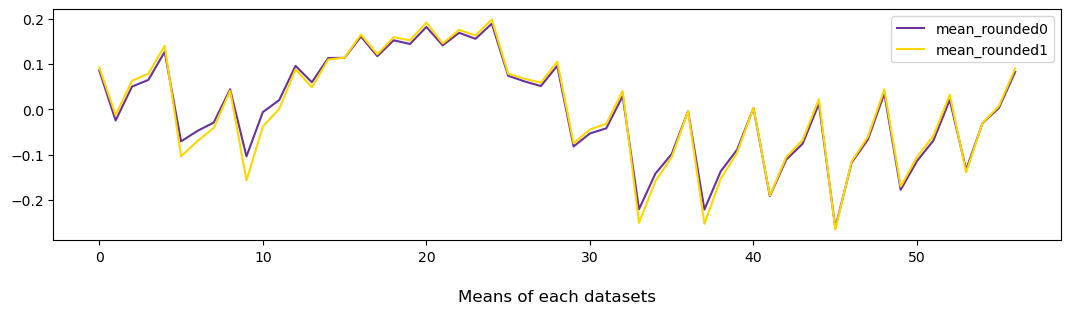

In [31]:
# Plotting to visualize the difference between mean_rouded0 and mean_rounded1
plt.plot(mean_rounded0, color = color0, label='mean_rounded0')
plt.plot(mean_rounded1, color = color1, label='mean_rounded1')

plt.title("Means of each datasets",y=-0.3)

plt.legend()
plt.show()

After displaying all the 256 traces, we can see that only the samples between 9 and 10 exhibit strong leakage. We will focus on those.

⚠️  It’s possible that the leakage shifts depending on the pattern matching obtained. Adjust it to the window where you observe the most leakage.

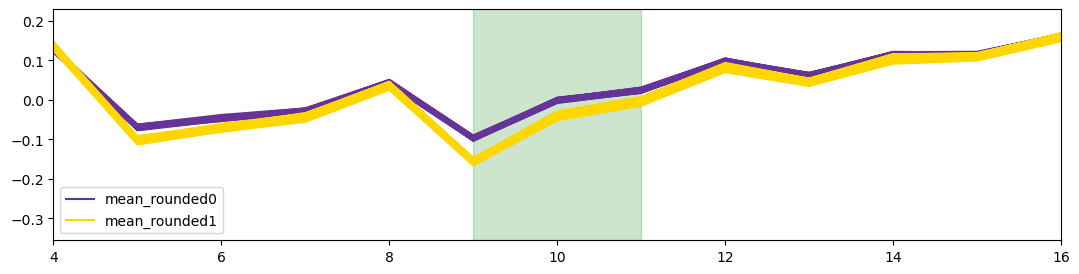

In [32]:
reduced_start = 9
reduced_len   = 2
reduced_end   = reduced_start + reduced_len

trace = dataset_building_rounded0[0]
for compress_index in range(0, N):
    start_window, end_window = get_compress_index_window(compress_index)
    test = trace[start_window: end_window + 1]
    if compress_index == 0:
        plt.plot(test, color = color0, label = 'mean_rounded0')
    else:
        plt.plot(test, color = color0)
    
trace = dataset_building_rounded1[0]
for compress_index in range(0, N):
    start_window, end_window = get_compress_index_window(compress_index)
    test = trace[start_window: end_window + 1]
    if compress_index == 0:
        plt.plot(test, color = color1, label = 'mean_rounded1')
    else:
        plt.plot(test, color = color1)

plt.legend()
plt.axvspan(reduced_start, reduced_end, color = "green", alpha = 0.2)
plt.xlim(reduced_start-5, reduced_end+5)
plt.show()

In [33]:
reduced_mean_rounded0 = mean_rounded0[reduced_start:reduced_end + 1]
reduced_mean_rounded1 = mean_rounded1[reduced_start:reduced_end + 1]

In [34]:
# We redefine the function that computes the window on the restricted samples
def get_compress_index_window_reduced(compress_index):
    start_compress_index =  start_index_compress_coeff0\
                          + compress_index*approximate_length_compress_coeff\
                          + (compress_index//nb_coeffs)*(nb_coeffs-1)*distance_forj_loop_forj_loop\
                          + (compress_index%nb_coeffs)*distance_forj_loop_forj_loop\
                          + (compress_index//nb_coeffs)*distance_fori_loop_forj_loop
    start_compress_index = start_compress_index + reduced_start
    end_compress_index   = start_compress_index + reduced_len
    return start_compress_index, end_compress_index
    

### Parallel Chosen Ciphertext Attack assisted with Side-channel 

Refer to the paper for the choice of the malicious $\mathbf{u}$ and $v$

In [35]:
malicious_v_coeff = -(Q - 1)//4
malicious_u_coeff =  (Q - 1)//16

We visualize the range of possible values for the secret coefficient based on the result of the compression given by the side-channel traces
![test](graphe.PNG)

In [36]:
def get_malicious_v(previous_v, previous_rounding, stage):
    """
    Allows to get the new malicious v for the current stage, based
    on the previous malicious v and the result of the rounding 
    
    Inputs:
    --------
    previous_v        (int): previous stage malicious v
    previous_rounding (int): previous rounding( 0 or 1)
    stage             (int): stage of the attack
    
    Outputs:
    --------
      (int): corresponding malicious v for this stage 
    """
    return previous_v - pow(-1, previous_rounding)*(416//(stage))

### Loading the dataset for matching

In [37]:
# Load the attack dataset 
name_of_file = f"{global_path_matching}datasets_matching.npz"
dataset_matching = np.load(name_of_file)

name_files = dataset_matching.files
print(f"Files found in {name_of_file}:")
for name_file in name_files:
    print(f" - {name_file} containing {dataset_matching[name_file].shape[0]} traces of {dataset_matching[name_file].shape[1]} samples each")

print("")

Files found in ./Dataset_matching/datasets_matching.npz:
 - poly0_distinguisher_queries containing 3 traces of 24400 samples each
 - poly1_distinguisher_queries containing 3 traces of 24400 samples each



Each trace in the matching datasets correspond to one level of the graph 

### Attack execution

In [38]:
# Graph transformed into dictionary
secret_path_dict = {repr([0])      : [-3, -2, -1, 0],
                    repr([1])      : [1, 2, 3],
                    repr([0, 0])   : [-3, -2],
                    repr([0, 1])   : [-1, 0],
                    repr([1, 0])   : [1, 2],
                    repr([1, 1])   : [3],
                    repr([0, 0, 0]): [-3],
                    repr([0, 0, 1]): [-2],
                    repr([0, 1, 0]): [-1],
                    repr([0, 1, 1]): [0],
                    repr([1, 0, 0]): [1],
                    repr([1, 0, 1]): [2],
                    repr([1, 1, 0]): [3],
                    repr([1, 1, 1]): [4]}

In [39]:
# Initializing the secret key, the actual value will be computed later
found_polyvec_sk_PKE = [[None for coeff_ in range(N)] for poly_ in range(K)]

In [40]:
%%time

# Keeps in memory the binary of the dictionnary 
MATCH = [[[] for coeff_ in range(N)] for poly_ in range(K)]

for poly_targeted in range(K):
    for guess_round in range(3):    
        for coeff_index in range(N):
            start_window, end_window = get_compress_index_window_reduced(coeff_index)
            # Each trace is used to distinguish between coeffs rounded to 0 and coeffs rounded to 1
            trace_compress_coeff = dataset_matching[name_files[poly_targeted]][guess_round][start_window:end_window + 1]
            
            # We choose the euclidian distance as a distinguisher to determine whether the trace chosen belongs to the 
            # set of traces rounded to 0 or the set of traces rounded to 1
            norm_rounded0 = np.linalg.norm(reduced_mean_rounded0 - trace_compress_coeff)
            norm_rounded1 = np.linalg.norm(reduced_mean_rounded1 - trace_compress_coeff)

            norms = [norm_rounded0, norm_rounded1]
            MATCH[poly_targeted][coeff_index].append(norms.index(min(norms)))

CPU times: user 406 ms, sys: 46.4 ms, total: 453 ms
Wall time: 452 ms


In [41]:
# Found secret key
for poly_ in range(K):
    for coeff_, match_path in enumerate(MATCH[poly_]):
        found_polyvec_sk_PKE[poly_][coeff_] = secret_path_dict[repr(match_path)][0]
print("The secret Key found is : ", found_polyvec_sk_PKE)

The secret Key found is :  [[1, 2, -1, 0, 0, 0, -1, -1, -2, 1, 0, 1, 0, -1, 1, 0, 1, 2, 0, -1, -2, -2, -1, -2, 1, 0, 0, 0, 0, 0, 0, 1, -2, -2, -2, 1, 0, -2, -1, 1, -1, 1, 0, 1, 0, 0, 0, 1, 1, -1, -1, -1, 0, 0, -2, 0, -1, -1, -2, -1, -1, 0, 2, 1, 0, 1, 0, 0, -2, 1, 2, 0, -1, -1, 1, 2, 2, -1, 0, -1, 2, -1, 0, -1, 0, 1, 2, -2, 0, 0, 1, -2, -1, 1, -1, 1, 0, 1, 2, -1, 2, 0, 0, -1, 1, -1, -1, -1, 0, 1, -2, 0, -2, 1, 0, 0, 0, -1, -1, 2, -2, 1, -2, 1, 1, -1, -1, 1, -2, 0, -2, -1, 1, 0, 0, 0, 1, -1, 0, 1, 2, 0, 0, 1, 0, 1, 1, 1, 2, 0, -3, -3, 0, 2, 0, 1, 1, 1, -2, 0, -1, 2, -1, 0, -2, -1, 1, 3, 0, -2, 0, 0, -1, 3, 1, 0, 0, -1, 0, 0, -2, 1, 0, -2, 0, 2, 1, 0, -1, 1, 1, 3, 0, -1, 1, -2, 1, 0, -1, 0, 0, -2, 0, 0, -3, 2, 1, 2, -1, -1, 0, 0, 3, 0, -2, -1, -1, -2, -1, 1, 0, 0, 0, -1, -1, -2, 1, 0, -2, -1, -2, 0, -1, 1, -1, 2, 1, 0, -2, 1, 0, 0, 0, 1, -1, 2, -1, 0, 0, 0, 1, 0, -1, -1, -2, -1], [2, 1, 1, 2, 1, 0, -1, 1, 0, 1, -1, -2, 1, 3, 0, 1, 2, 1, 1, 0, -2, 1, 2, 1, 0, -1, 0, -1, 0, -2, 1, 1, 0, -2

#### Loading the targeted secret key to verify if the guess was correct

In [42]:
# Read specified number of keys from the KAT file (from 1 to 100)
number_keys_to_read = 1 
keys_file_name = f'../Common_functions/PQCkemKAT_{KEM_SK_BYTES}.rsp'
PK_KEM, SK_KEM = read_keys_from_KAT(number_keys_to_read, keys_file_name = keys_file_name)
 
# Depending on the number of keys read (from 0 to number_keys_to_read - 1)
index_sk_targeted = 0
 
# Extracting the sk_KEM from the dictionnary of keys as an hex string
hex_sk_KEM = SK_KEM[index_sk_targeted]
 
# Extracting the sk_PKE from the sk_KEM as an hex string
hex_sk_PKE = hex_sk_KEM[:2*SK_BYTES]
 
# Converting the sk_PKE to polynomial vector representation
polyvec_sk_PKE = hex_sk_to_int_sk(hex_sk_PKE)
 
print("sk trageted:", polyvec_sk_PKE)

sk trageted: [[1, 2, -1, 0, 0, 0, -1, -1, -2, 1, 0, 1, 0, -1, 1, 0, 1, 2, 0, -1, -2, -2, -1, -2, 1, 0, 0, 0, 0, 0, 0, 1, -2, -2, -2, 1, 0, -2, -1, 1, -1, 1, 0, 1, 0, 0, 0, 1, 1, -1, -1, -1, 0, 0, -2, 0, -1, -1, -2, -1, -1, 0, 2, 1, 0, 1, 0, 0, -2, 1, 2, 0, -1, -1, 1, 2, 2, -1, 0, -1, 2, -1, 0, -1, 0, 1, 2, -2, 0, 0, 1, -2, -1, 1, -1, 1, 0, 1, 2, -1, 2, 0, 0, -1, 1, -1, -1, -1, 0, 1, -2, 0, -2, 1, 0, 0, 0, -1, -1, 2, -2, 1, -2, 1, 1, -1, -1, 1, -2, 0, -2, -1, 1, 0, 0, 0, 1, -1, 0, 1, 2, 0, 0, 1, 0, 1, 1, 1, 2, 0, -3, -3, 0, 2, 0, 1, 1, 1, -2, 0, -1, 2, -1, 0, -2, -1, 1, 3, 0, -2, 0, 0, -1, 3, 1, 0, 0, -1, 0, 0, -2, 1, 0, -2, 0, 2, 1, 0, -1, 1, 1, 3, 0, -1, 1, -2, 1, 0, -1, 0, 0, -2, 0, 0, -3, 2, 1, 2, -1, -1, 0, 0, 3, 0, -2, -1, -1, -2, -1, 1, 0, 0, 0, -1, -1, -2, 1, 0, -2, -1, -2, 0, -1, 1, -1, 2, 1, 0, -2, 1, 0, 0, 0, 1, -1, 2, -1, 0, 0, 0, 1, 0, -1, -1, -2, -1], [2, 1, 1, 2, 1, 0, -1, 1, 0, 1, -1, -2, 1, 3, 0, 1, 2, 1, 1, 0, -2, 1, 2, 1, 0, -1, 0, -1, 0, -2, 1, 1, 0, -2, 1, 1, 0, -1,

In [43]:
if found_polyvec_sk_PKE == polyvec_sk_PKE :
    print(f"No errors, you have correctly guessed the secret key")
else :
    print(f'You did not guess the secret key') 
    cpt_wron_coeffs = 0
    
    for poly_ in range(K):
        for coeff_ in range(N):
            if found_polyvec_sk_PKE[poly_][coeff_] != polyvec_sk_PKE[poly_][coeff_]:
                cpt_wron_coeffs += 1
    
    print(f"Number of wrongly guessed coefficients: {cpt_wron_coeffs}")

No errors, you have correctly guessed the secret key
